In [12]:
from typing import Union
from typing import List
from typing import Optional


from contextlib import suppress
from collections.abc import Mapping
from collections import Counter
from transformers.generation import PhrasalConstraint
from transformers.generation import DisjunctiveConstraint
from transformers import GenerationConfig
from safe.trainer.model import SAFEDoubleHeadsModel
from loguru import logger
from tqdm.auto import tqdm
from pathlib import Path

import itertools
import os
import re
import torch
import random
import pandas as pd


In [85]:
from safe.converter import GroupSELFIESConverter
from safe.tokenizer import GroupSELFIESTokenizer
import datamol as dm
import re

# Set to useful30.txt path
GROUP_SELFIES_GRAMMAR_PATH = Path.cwd() / 'safe' / 'safe' / 'assets' / 'useful30.txt'

class GroupSELFIESDesign:
    """Molecular generation using SAFE pretrained model"""

    _DEFAULT_MAX_LENGTH = 1024  # default max length used during training
    _DEFAULT_MODEL_PATH = "datamol-io/safe-gpt"

    def __init__(
        self,
        model: Union[SAFEDoubleHeadsModel, str],
        tokenizer: Union[str, GroupSELFIESTokenizer],
        generation_config: Optional[Union[str, GenerationConfig]] = None,
        encoder: Optional[GroupSELFIESConverter] = None,
        verbose: bool = True,
    ):
        """SAFEDesign constructor

        Args:
            model: input SAFEDoubleHeadsModel to use for generation
            tokenizer: input SAFETokenizer to use for generation
            generation_config: input GenerationConfig to use for generation
            safe_encoder: custom safe encoder to use
            verbose: whether to print out logging information during generation
        """
        if isinstance(model, os.PathLike):
            model = SAFEDoubleHeadsModel.from_pretrained(model)

        if isinstance(tokenizer, os.PathLike):
            tokenizer = GroupSELFIESTokenizer.load(tokenizer)

        model.eval()
        self.model = model
        self.tokenizer = tokenizer
        if isinstance(generation_config, os.PathLike):
            generation_config = GenerationConfig.from_pretrained(generation_config)
        if generation_config is None:
            generation_config = GenerationConfig.from_model_config(model.config)
        self.generation_config = generation_config
        for special_token_id in ["bos_token_id", "eos_token_id", "pad_token_id"]:
            if getattr(self.generation_config, special_token_id) is None:
                setattr(
                    self.generation_config, special_token_id, getattr(tokenizer, special_token_id)
                )

        self.verbose = verbose
        self.encoder = encoder or GroupSELFIESConverter() # TODO: Change this to GroupSELFIESConverter() after implementation

    @classmethod
    def load_default(
        cls, verbose: bool = False, model_dir: Optional[str] = None, device: str = None, encoder_grammar_filepath: str = None,
    ) -> "SAFEDesign":
        """Load default SAFEGenerator model

        Args:
            verbose: whether to print out logging information during generation
            model_dir: Optional path to model folder to use instead of the default one.
                If provided the tokenizer should be in the model_dir named as `tokenizer.json`
            device: optional device where to move the model
        """
        if model_dir is None or not model_dir:
            model_dir = cls._DEFAULT_MODEL_PATH
        model = SAFEDoubleHeadsModel.from_pretrained(model_dir)
        tokenizer = GroupSELFIESTokenizer.get_pretrained(os.path.join(model_dir, "tokenizer.json"))
        gen_config = GenerationConfig.from_pretrained(model_dir)
        encoder = GroupSELFIESConverter(grammar_filepath=encoder_grammar_filepath)
        
        if device is not None:
            model = model.to(device)
        return cls(model=model, tokenizer=tokenizer, generation_config=gen_config, verbose=verbose, encoder=encoder)
    
    @staticmethod
    def get_group_selfies_splits(group_selfies_str):
        split_pattern = re.compile(r'\[.+?\]')
        splits = re.findall(split_pattern, group_selfies_str)
        
        return splits
        
    @staticmethod
    def get_wildcard_indices(splits):
        return [ i for i, s in enumerate(splits) if "*" in s ]
    
    def de_novo_generation(
        self,
        n_samples_per_trial: int = 10,
        sanitize: bool = False,
        n_trials: Optional[int] = None,
        decode_output: bool = False,
        **kwargs,
    ):
        """Perform de novo generation using the pretrained SAFE model.

        De novo generation is equivalent to not having any prefix.

        Args:
            n_samples_per_trial: number of new molecules to generate
            sanitize: whether to perform sanitization, aka, perform control to ensure what is asked is what is returned
            n_trials: number of randomization to perform
            kwargs: any argument to provide to the underlying generation function
        """
        # EN: lazy programming much ?
        kwargs.setdefault("how", "random")
        if kwargs["how"] != "random" and not kwargs.get("do_sample"):
            logger.warning(
                "I don't think you know what you are doing ... for de novo generation `do_sample=True` or `how='random'` is expected !"
            )

        total_sequences = []
        n_trials = n_trials or 1
        for _ in tqdm(range(n_trials), disable=(not self.verbose), leave=False):
            sequences = self._generate(n_samples=n_samples_per_trial, **kwargs)
            total_sequences.extend(sequences)
        total_sequences = self._decode_groupselfies(
            total_sequences, 
            remove_invalid=sanitize,
            decode_output=decode_output,
        )
        

        if sanitize and self.verbose:
            logger.info(
                f"After sanitization, {len(total_sequences)} / {n_samples_per_trial*n_trials} ({len(total_sequences)*100/(n_samples_per_trial*n_trials):.2f} %) generated molecules are valid !"
            )
        return total_sequences
        
    def _decode_groupselfies(
        self, sequences: List[str], remove_invalid: bool = False, decode_output: bool = False
    ):
        """Decode a group SELFIES sequence into a molecule

        Args:
            sequence: group SELFIES sequence to decode
            remove_invalid: whether to remove invalid safe strings or keep them
        """

        def _decode_fn(x):
            # return sf.decode(
            #     x,
            #     as_mol=False,
            #     fix=True,
            #     remove_added_hs=True,
            #     canonical=canonical,
            #     ignore_errors=True,
            #     remove_dummies=True,
            # )
            return self.encoder.decoder(x)

        output_strings = sequences
        
        if decode_output:
            if len(sequences) > 100:
                output_strings = dm.parallelized(_decode_fn, sequences, n_jobs=-1)
            else:
                output_strings = [_decode_fn(x) for x in sequences]
                
        if remove_invalid:
            output_strings = [x for x in output_strings if x is not None]

        return output_strings
        
    def _generate(
        self,
        n_samples: int = 1,
        prefix: Optional[str] = None,
        max_length: Optional[int] = 100,
        how: Optional[str] = "random",
        num_beams: Optional[int] = None,
        num_beam_groups: Optional[int] = None,
        do_sample: Optional[bool] = None,
        **kwargs,
    ):
        """Sample a new sequence using the underlying hugging face model.
        This emulates the izanagi sampling models, if you wish to retain the hugging face generation
        behaviour, either call the hugging face functions directly or overwrite this function

        ??? note "Generation Parameters"
            From the hugging face documentation:

            * `greedy decoding` if how="greedy" and num_beams=1 and do_sample=False.
            * `multinomial sampling` if num_beams=1 and do_sample=True.
            * `beam-search decoding` if how="beam" and num_beams>1 and do_sample=False.
            * `beam-search multinomial` sampling by calling if beam=True, num_beams>1 and do_sample=True or how="random" and num_beams>1
            * `diverse beam-search decoding` if num_beams>1 and num_beam_groups>1

            It's also possible to ignore the 'how' shortcut and directly call the underlying generation methods using the proper arguments.
            Learn more here: https://huggingface.co/docs/transformers/v4.32.0/en/main_classes/text_generation#transformers.GenerationConfig
            Under the hood, the following will be applied depending on the arguments:

            * greedy decoding by calling greedy_search() if num_beams=1 and do_sample=False
            * contrastive search by calling contrastive_search() if penalty_alpha>0. and top_k>1
            * multinomial sampling by calling sample() if num_beams=1 and do_sample=True
            * beam-search decoding by calling beam_search() if num_beams>1 and do_sample=False
            * beam-search multinomial sampling by calling beam_sample() if num_beams>1 and do_sample=True
            * diverse beam-search decoding by calling group_beam_search(), if num_beams>1 and num_beam_groups>1
            * constrained beam-search decoding by calling constrained_beam_search(), if constraints!=None or force_words_ids!=None
            * assisted decoding by calling assisted_decoding(), if assistant_model is passed to .generate()

        Args:
            n_samples: number of sequences to return
            safe_prefix: Prefix to use in sampling, should correspond to a safe fragment
            max_length : maximum length of sampled sequence
            how: which sampling method to use: "beam", "greedy" or "random". Can be used to control other parameters by setting defaults
            num_beams: number of beams for beam search. 1 means no beam search, unless beam is specified then max(n_samples, num_beams) is used
            num_beam_groups: number of beam groups for diverse beam search
            do_sample: whether to perform random sampling or not, equivalent to setting random to True
            kwargs: any additional keyword argument to pass to the underlying sampling `generate`  from hugging face transformer

        Returns:
            samples: list of sampled molecules, including failed validation

        """
        # pretrained_tk = self.tokenizer.get_pretrained()
        pretrained_tk = self.tokenizer
        if getattr(pretrained_tk, "model_max_length") is None:
            setattr(
                pretrained_tk,
                "model_max_length",
                self._DEFAULT_MAX_LENGTH,  # this was the defaul
            )

        input_ids = prefix
        if isinstance(prefix, str):
            # EN: should we address the special token issues
            input_ids = pretrained_tk(
                prefix,
                return_tensors="pt",
            )

        num_beams = num_beams or None
        do_sample = do_sample or False

        if how == "random":
            do_sample = True

        elif how is not None and "beam" in how:
            num_beams = max((num_beams or 0), n_samples)

        is_greedy = how == "greedy" or (num_beams in [0, 1, None]) and do_sample is False

        kwargs["do_sample"] = do_sample
        if num_beams is not None:
            kwargs["num_beams"] = num_beams
        if num_beam_groups is not None:
            kwargs["num_beam_groups"] = num_beam_groups
        kwargs["output_scores"] = True
        kwargs["return_dict_in_generate"] = True
        kwargs["num_return_sequences"] = n_samples
        kwargs["max_length"] = max_length
        kwargs.setdefault("early_stopping", True)
        # EN we don't do anything with the score that the model might return on generate ...
        if not isinstance(input_ids, Mapping):
            input_ids = {"inputs": None}
        else:
            # EN: we remove the EOS token added before running the prediction
            # because the model output nonsense when we keep it.
            # I don't know why it works for text generation but not here
            for k in input_ids:
                input_ids[k] = input_ids[k][:, :-1]

        for k, v in input_ids.items():
            if torch.is_tensor(v):
                input_ids[k] = v.to(self.model.device)

        if is_greedy:
            kwargs["num_return_sequences"] = 1
            if num_beams is not None and num_beams > 1:
                raise ValueError("Cannot set num_beams|num_beam_groups > 1 for greedy")
            # under greedy decoding there can only be a single solution
            # we just duplicate the solution several time for efficiency
            outputs = self.model.generate(
                **input_ids,
                generation_config=self.generation_config,
                **kwargs,
            )
            sequences = [
                pretrained_tk.decode(outputs.sequences.squeeze(), skip_special_tokens=True)
            ] * n_samples

        else:
            outputs = self.model.generate(
                **input_ids,
                generation_config=self.generation_config,
                **kwargs,
            )
            sequences = pretrained_tk.batch_decode(outputs.sequences, skip_special_tokens=True)
        return sequences

    def motif_extension(
        self,
        motif: Union[str, dm.Mol],
        n_samples_per_trial: int = 10,
        n_trials: Optional[int] = 1,
        sanitize: bool = False,
        do_not_fragment_further: Optional[bool] = False,
        random_seed: Optional[int] = None,
        **kwargs,
    ):
        """Perform motif extension using the pretrained SAFE model.
        Motif extension is really just scaffold decoration underlying.

        Args:
            scaffold: scaffold (with attachment points) to decorate
            n_samples_per_trial: number of new molecules to generate for each randomization
            n_trials: number of randomization to perform
            do_not_fragment_further: whether to fragment the scaffold further or not
            sanitize: whether to sanitize the generated molecules and check
            random_seed: random seed to use
            kwargs: any argument to provide to the underlying generation function
        """
        return self.scaffold_decoration(
            motif,
            n_samples_per_trial=n_samples_per_trial,
            n_trials=n_trials,
            sanitize=sanitize,
            do_not_fragment_further=do_not_fragment_further,
            random_seed=random_seed,
            # add_dot=True,
            **kwargs,
        )
    
    def scaffold_decoration(
            self,
            scaffold: Union[str, dm.Mol],
            n_samples_per_trial: int = 10,
            n_trials: Optional[int] = 1,
            do_not_fragment_further: Optional[bool] = False,
            sanitize: bool = False,
            random_seed: Optional[int] = None,
            # add_dot=True,
            **kwargs,
        ):
            """Perform scaffold decoration using the pretrained SAFE model
    
            For scaffold decoration, we basically starts with a prefix with the attachment point.
            We first convert the prefix into valid safe string.
    
            Args:
                scaffold: scaffold (with attachment points) to decorate
                n_samples_per_trial: number of new molecules to generate for each randomization
                n_trials: number of randomization to perform
                do_not_fragment_further: whether to fragment the scaffold further or not
                sanitize: whether to sanitize the generated molecules and check if the scaffold is still present
                random_seed: random seed to use
                kwargs: any argument to provide to the underlying generation function
            """
    
            total_sequences = self._completion(
                fragment=scaffold,
                n_samples_per_trial=n_samples_per_trial,
                n_trials=n_trials,
                do_not_fragment_further=do_not_fragment_further,
                sanitize=sanitize,
                random_seed=random_seed,
                # add_dot=add_dot,
                is_encoded=False,
                **kwargs,
            )
            # if we require sanitization
            # then we should filter out molecules that do not match the requested
            # if sanitize:
            #     total_sequences = sf.utils.filter_by_substructure_constraints(total_sequences, scaffold)
            #     if self.verbose:
            #         logger.info(
            #             f"After sanitization, {len(total_sequences)} / {n_samples_per_trial*n_trials} ({len(total_sequences)*100/(n_samples_per_trial*n_trials):.2f} %)  generated molecules are valid !"
            #         )
            return total_sequences

    def _completion(
        self,
        fragment: Union[str, dm.Mol],
        n_samples_per_trial: int = 10,
        n_trials: Optional[int] = 1,
        do_not_fragment_further: Optional[bool] = False,
        sanitize: bool = False,
        random_seed: Optional[int] = None,
        # add_dot: Optional[bool] = False,
        is_encoded: Optional[bool] = False,
        **kwargs,
    ):
        """Perform sentence completion using a prefix fragment

        Args:
            scaffold: scaffold (with attachment points) to decorate
            n_samples_per_trial: number of new molecules to generate for each randomization
            n_trials: number of randomization to perform
            do_not_fragment_further: whether to fragment the scaffold further or not
            sanitize: whether to sanitize the generated molecules
            random_seed: random seed to use
            is_encoded: whether the smiles is already encoded as a group SELFIES string
            add_dot: whether to add a dot at the end of the fragments to signal to the model that we want to generate a distinct fragment.
            kwargs: any argument to provide to the underlying generation function
        """

        # EN: lazy programming much ?
        kwargs.setdefault("how", "random")
        if kwargs["how"] != "random" and not kwargs.get("do_sample"):
            logger.warning(
                "I don't think you know what you are doing ... for de novo generation `do_sample=True` or `how='random'` is expected !"
            )

        # Step 1: we conver the fragment into the relevant safe string format
        # we use the provided safe encoder with the slicer that was expected

        rng = random.Random(random_seed)
        new_seed = rng.randint(1, 1000)

        total_sequences = []
        n_trials = n_trials or 1
        for _ in tqdm(range(n_trials), disable=(not self.verbose), leave=False):
            if is_encoded:
                encoded_fragment = fragment
            else:
                with dm.without_rdkit_log():
                    context_mng = (
                        sf.utils.attr_as(self.encoder, "slicer", None)
                        if do_not_fragment_further
                        else suppress()
                    )
                    old_slicer = getattr(self.encoder, "slicer", None)
                    with context_mng:
                        try:
                            encoded_fragment = self.encoder.encoder(
                                fragment,
                                # canonical=False,
                                # randomize=True,
                                # constraints=None,
                                # allow_empty=True,
                                # seed=new_seed,
                            )

                        except Exception as e:
                            if self.verbose:
                                logger.error(e)
                            # raise sf.SAFEEncodeError(f"Failed to encode {fragment}") from e
                        finally:
                            if old_slicer is not None:
                                self.encoder.slicer = old_slicer

            # if add_dot and encoded_fragment.count("(") == encoded_fragment.count(")"):
            #     encoded_fragment = encoded_fragment.rstrip(".") + "."
            print(fragment, encoded_fragment)
            splits = self.get_group_selfies_splits(encoded_fragment)
            wildcard_indices = self.get_wildcard_indices(splits)
            if len(wildcard_indices) > 1:
                raise Exception(f"Sequence completion expects only one attachment point, but found {len(wildcard_indices)}")
                
            # Fragment wildcard is the first token, need to invert for generation
            wildcard_index = wildcard_indices[0]
            if wildcard_index == 0:
                splits = splits[1:][::-1]
                # splits = splits[1:]
                num_tokens = len(splits)
                encoded_fragment = "".join(splits)
            else:
                prefix_frag = "".join(splits[:wildcard_index])
                suffix_frag = "".join(splits[wildcard_index+1:])
                encoded_fragment = prefix_frag
                
            sequences = self._generate(
                n_samples=n_samples_per_trial, prefix=encoded_fragment, **kwargs
            )

            sequences = self._decode_groupselfies(sequences, remove_invalid=sanitize, decode_output=False)
            print(sequences)
            # Invert back the generated sequence
            if wildcard_index == 0:
                sequences = [ "".join(self.get_group_selfies_splits(s)[::-1]) for s in sequences ]
                # rearranged_sequences = []
                # for s in sequences:
                #     splits = self.get_group_selfies_splits(s)
                #     rearranged = "".join(splits[num_tokens:] + splits[:num_tokens])
                #     rearranged_sequences.append(rearranged)
                # sequences = rearranged_sequences
                
            # Add the suffix frag to every sequence
            else:
                sequences = [ s+suffix_frag for s in sequences ]
                
            total_sequences.extend(sequences)

        return total_sequences
    

In [11]:
from pathlib import Path
import pandas as pd


In [40]:
df = pd.read_csv("groupselfies_generated_10K.csv")
df

,group_selfies
0,[C][C][O][C][=Branch][=O][pop][C][Branch][N][C...
1,[:0frag10][=Branch][C][S][C][=N][N][=C][Branch...
2,[C][C][C][C][:0frag15][=C][N][=C][Branch][N][C...
3,[:0frag10][=Branch][:0frag28][Ring2][N][=N][C]...
4,[:0frag10][Branch][:0frag0][=Branch][C][Branch...
...,...
995,[:0frag10][=Branch][N][C][C][=C][S][C][=Ring1]...
996,[C][C][C][=N][N][=C][Branch][N][C][C][=N][N][B...
997,[:0frag10][=Branch][:2frag28][Branch][Br][pop]...
998,[C][C][=C][Branch][C][=Branch][=O][pop][O][C][...


In [41]:
from safe.converter import GroupSELFIESConverter

converter = GroupSELFIESConverter(grammar_filepath=GROUP_SELFIES_GRAMMAR_PATH)
converter.encoder(converter.decoder(df['group_selfies'].values[0]))

'[C][C][O][C][=Branch][=O][pop][C][C][C][C][C][C][C][Branch][C][C][Ring1][Ring1][pop][N][Branch][C][=Branch][=C][:0frag1][pop][N][Ring1][P][pop][Ring1][#Branch]'

In [199]:
gs_designer = GroupSELFIESDesign.load_default(verbose=True, 
                                           model_dir="/home/jonathanlim/safe/safe/expts/output/groupselfies_2/checkpoint-244000/",
                                           device = "cuda",
                                           encoder_grammar_filepath=GROUP_SELFIES_GRAMMAR_PATH)

In [9]:
N_SAMPLES = 10000
N_TRIALS = 4

In [62]:
for trial in range(1, N_TRIALS+1):
    print(f"Trial {trial}")
    # Sample in batches of 1000 to prevent OOM
    generated = gs_designer.de_novo_generation(sanitize=False, n_samples_per_trial=1000, n_trials=N_SAMPLES//1000, how='random', max_length=150)
    converted = [ converter.decoder(gen) for gen in generated ]
    df = pd.DataFrame({'group_selfies': generated, 'smiles': converted })
    df.to_csv(f"groupselfies_generated_10K_{trial}.csv", index=None)

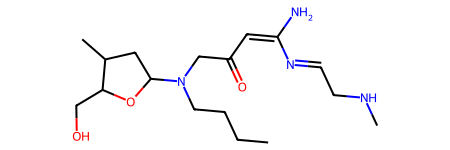

In [31]:
from rdkit import Chem

index = 3
Chem.MolFromSmiles(df['smiles'].values[index])

[16:41:22] Incomplete atom labelling, cannot make bond
[16:41:22] Incomplete atom labelling, cannot make bond
[16:41:22] Incomplete atom labelling, cannot make bond


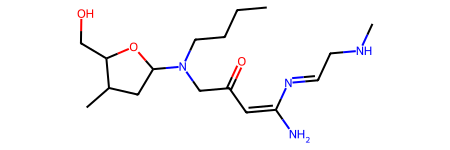

In [32]:
converter.decoder(df['group_selfies'].values[index], as_mol=True)

In [13]:
from tdc import Evaluator
diversity_evaluator = Evaluator(name = 'Diversity')
validity_evaluator = Evaluator(name = 'Validity')
uniqueness_evaluator = Evaluator(name = 'Uniqueness')

In [18]:
df = pd.read_csv("groupselfies_generated_10K_1.csv")
final_generated = df["smiles"].values

In [19]:
results = {}
results["validity@10k"] = validity_evaluator(final_generated)
results["uniqueness@10k"] = uniqueness_evaluator([x for x in final_generated if x])
results["diversity@10k"] = diversity_evaluator([x for x in final_generated if x])
results["validity@1k"] = validity_evaluator(final_generated[:1000])
results["uniqueness@1k"] = uniqueness_evaluator([x for x in final_generated if x][:1000])
results["diversity@1k"] = diversity_evaluator([x for x in final_generated if x][:1000])

In [20]:
results

{'validity@10k': 1.0,
 'uniqueness@10k': 0.9982,
 'diversity@10k': 0.8867271048360721,
 'validity@1k': 1.0,
 'uniqueness@1k': 0.999,
 'diversity@1k': 0.8893262224365022}

## Scaffold generation tasks

In [86]:
drugs_df = pd.read_csv("drugs.csv")

benchmark_drugs = ["BARICITINIB", 
         "CYCLOTHIAZIDE", 
         "ELIGLUSTAT",
         "ERLOTINIB",
         "FUTIBATINIB",
         "LESINURAD",
         "LIOTHYRONINE",
         "LOVASTATIN",
         "MARIBAVIR",
         "SPIRAPRIL"
        ]

drugs_df = drugs_df[drugs_df["pref_name"].isin(benchmark_drugs)].reset_index(drop=True)

In [15]:
drugs_df

,dosed_ingredient,indication_class,molecule_chembl_id,molecule_type,oral,pref_name,therapeutic_flag,usan_stem,usan_stem_definition,usan_year,withdrawn_flag,smiles,inchikey,slices,morphing,motif,scaffold,superstructure
0,False,Enzyme Inhibitor (angiotensin-converting),CHEMBL431,Small molecule,True,SPIRAPRIL,True,-pril,antihypertensives (ACE inhibitors),1987.0,False,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CC2(...,HRWCVUIFMSZDJS-SZMVWBNQSA-N,"['[7*]c1ccccc1', '[8*]CC[C@H](N[C@@H](C)C([19*...",[7*]c1ccccc1.[17*]N1CC2(C[C@H]1C(=O)O)SCCS2,[17*]N1CC2(C[C@H]1C(=O)O)SCCS2,[1*][C@H](CCc1ccccc1)N[C@@H]([2*])C(=O)N1CC2(C...,O=C(CNCCCc1ccccc1)N1CCC2(C1)SCCS2
1,True,Antihypertensive; Diuretic,CHEMBL61593,Small molecule,True,CYCLOTHIAZIDE,True,-thiazide,diuretics (thiazide derivatives),1963.0,False,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,BOCUKUHCLICSIY-UHFFFAOYSA-N,['[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1'...,[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1.[1...,[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1,[1*]c1cc2c(cc1[2*])NC(C1CC3C=CC1C3)NS2(=O)=O,O=S1(=O)NC(C2CC3C=CC2C3)Nc2ccccc21
2,True,NaN,CHEMBL515408,Small molecule,True,MARIBAVIR,True,-vir,antivirals,1998.0,False,CC(C)Nc1nc2cc(Cl)c(Cl)cc2n1[C@H]1O[C@@H](CO)[C...,KJFBVJALEQWJBS-XUXIUFHCSA-N,"['[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21', None, '...",[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21.[14*][C@H]1...,[14*][C@H]1O[C@@H](CO)[C@H](O)[C@@H]1O,[1*]c1nc2cc([2*])c([3*])cc2n1[C@H]1O[C@@H]([4*...,c1ccc2c(c1)ncn2[C@@H]1CCCO1
3,True,NaN,CHEMBL3701238,Small molecule,True,FUTIBATINIB,True,-tinib,tyrosine kinase inhibitors,2019.0,False,C=CC(=O)N1CC[C@H](n2nc(C#Cc3cc(OC)cc(OC)c3)c3c...,KEIPNCCJPRMIAX-HNNXBMFYSA-N,"['[8*][C@H]1CCN(C(=O)C=C)C1', '[7*]n1nc(C#C[13...",[8*][C@H]1CCN(C(=O)C=C)C1.[12*]c1cc(OC)cc(OC)c1,[8*][C@H]1CCN(C(=O)C=C)C1,[1*]N1CC[C@H](n2nc(C#Cc3cc([2*])cc([3*])c3)c3c...,C(#Cc1nn([C@H]2CCNC2)c2ncncc12)c1ccccc1
4,True,NaN,CHEMBL2105759,Small molecule,True,BARICITINIB,True,-tinib,tyrosine kinase inhibitors: tyrosine kinase in...,2011.0,False,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,XUZMWHLSFXCVMG-UHFFFAOYSA-N,"['[11*]C1(CC#N)CN(S(=O)(=O)CC)C1', '[7*]n1cc([...",[11*]C1(CC#N)CN(S(=O)(=O)CC)C1.[13*]c1ncnc2[nH...,[11*]C1(CC#N)CN(S(=O)(=O)CC)C1,[1*]N1CC([2*])(n2cc(-c3ncnc4[nH]ccc34)cn2)C1,c1nc(-c2cnn(C3CNC3)c2)c2cc[nH]c2n1
5,True,NaN,CHEMBL2110588,Small molecule,True,ELIGLUSTAT,True,-stat,enzyme inhibitors: glucosyltransferase inhibitors,2009.0,False,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...,FJZZPCZKBUKGGU-AUSIDOKSSA-N,"['[11*]N1CCCC1', '[12*]C[C@@H](NC(=O)CCCCCCC)[...",[11*]N1CCCC1.[17*]c1ccc2c(c1)OCCO2,[17*]c1ccc2c(c1)OCCO2,[1*][C@H](CN1CCCC1)[C@H]([2*])c1ccc2c(c1)OCCO2,c1cc2c(cc1CCCN1CCCC1)OCCO2
6,False,"Radioactive Agent,Thyroid Hormone",CHEMBL1544,Small molecule,True,LIOTHYRONINE,True,NaN,NaN,1963.0,False,N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O,AUYYCJSJGJYCDS-LBPRGKRZSA-N,"['[3*]C[C@H](N)C(=O)O', '[2*]c1cc(I)c(O[9*])c(...",[3*]C[C@H](N)C(=O)O.[8*]c1ccc(O)c(I)c1,[3*]C[C@H](N)C(=O)O,[1*]c1cc([2*])c(Oc2ccc([3*])c([4*])c2)c([5*])c1,c1ccc(Oc2ccccc2)cc1
7,True,Inhibitor (HMG-CoA reductase); Antihyperlipidemic,CHEMBL503,Small molecule,True,LOVASTATIN,True,-stat-,enzyme inhibitors: antihyperlipidemics (HMG-Co...,1987.0,False,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...,PCZOHLXUXFIOCF-BXMDZJJMSA-N,['[18*][C@@H]1[C@@H]2C(=C[C@H](C)C[C@@H]2OC(=O...,[18*][C@@H]1[C@@H]2C(=C[C@H](C)C[C@@H]2OC(=O)[...,[18*][C@@H]1[C@@H]2C(=C[C@H](C)C[C@@H]2OC(=O)[...,[1*][C@H]1C[C@@H]([2*])C=C2C=C[C@H]([3*])[C@H]...,O=C1CCC[C@@H](CC[C@H]2CC=CC3=CCCC[C@@H]32)O1
8,True,NaN,CHEMBL2105720,Small molecule,True,LESINURAD,True,-inurad,urate transporter inhibitors,2010.0,False,O=C(O)CSc1nnc(Br)n1-c1ccc(C2CC2)c2ccccc12,FGQFOYHRJSUHMR-UHFFFAOYSA-N,"['[11*]n1c(Br)nnc1SCC(=O)O', '[10*]c1ccc([15*]...",[11*]n1c(Br)nnc1SCC(=O)O.[14*]C1CC1,[11*]n1c(Br)nnc1SCC(=O)O,[1*]c1nnc([2*])n1-c1ccc(C2CC2)c2ccccc12,c1ccc2c(-n3cnnc3)ccc(C3CC3)c2c1
9,True,NaN,CHEMBL553,Small molecule,True,ERLOTINIB,True,-tinib,tyrosin

In [88]:
converter = GroupSELFIESConverter(grammar_filepath=GROUP_SELFIES_GRAMMAR_PATH)

In [93]:
tasks = ["morphing", "motif", "scaffold", "superstructure"]
prefix = "gs"

for task in tasks:
    drugs_df[f"{prefix}_{task}"] = drugs_df[task].apply(lambda x: converter.encoder(x))

drugs_df.to_csv("benchmark_drugs.csv", index=None)
drugs_df = pd.read_csv("benchmark_drugs.csv")

In [94]:
drugs_df

,dosed_ingredient,indication_class,molecule_chembl_id,molecule_type,oral,pref_name,therapeutic_flag,usan_stem,usan_stem_definition,usan_year,...,inchikey,slices,morphing,motif,scaffold,superstructure,gs_morphing,gs_motif,gs_scaffold,gs_superstructure
0,False,Enzyme Inhibitor (angiotensin-converting),CHEMBL431,Small molecule,True,SPIRAPRIL,True,-pril,antihypertensives (ACE inhibitors),1987.0,...,HRWCVUIFMSZDJS-SZMVWBNQSA-N,"['[7*]c1ccccc1', '[8*]CC[C@H](N[C@@H](C)C([19*...",[7*]c1ccccc1.[17*]N1CC2(C[C@H]1C(=O)O)SCCS2,[17*]N1CC2(C[C@H]1C(=O)O)SCCS2,[1*][C@H](CCc1ccccc1)N[C@@H]([2*])C(=O)N1CC2(C...,O=C(CNCCCc1ccccc1)N1CCC2(C1)SCCS2,[7*H0][:0frag28],[17*H0][N][C][C][Branch][C][:2chiral][Ring2][C...,[1*H0][:0chiral][Ring1][C][C][:0frag28][pop][R...,[:0frag10][=Branch][C][N][C][C][C][:0frag28][p...
1,True,Antihypertensive; Diuretic,CHEMBL61593,Small molecule,True,CYCLOTHIAZIDE,True,-thiazide,diuretics (thiazide derivatives),1963.0,...,BOCUKUHCLICSIY-UHFFFAOYSA-N,['[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1'...,[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1.[1...,[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1,[1*]c1cc2c(cc1[2*])NC(C1CC3C=CC1C3)NS2(=O)=O,O=S1(=O)NC(C2CC3C=CC2C3)Nc2ccccc21,[13*H0][C][N][:5frag4][Branch][S][=Branch][=O]...,[13*H0][C][N][:5frag4][Branch][S][=Branch][=O]...,[1*H0][:5frag4][Branch][2*H0][pop][Ring1][C][=...,[O][=S][=Branch][=O][pop][N][C][Branch][C][C][...
2,True,NaN,CHEMBL515408,Small molecule,True,MARIBAVIR,True,-vir,antivirals,1998.0,...,KJFBVJALEQWJBS-XUXIUFHCSA-N,"['[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21', None, '...",[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21.[14*][C@H]1...,[14*][C@H]1O[C@@H](CO)[C@H](O)[C@@H]1O,[1*]c1nc2cc([2*])c([3*])cc2n1[C@H]1O[C@@H]([4*...,c1ccc2c(c1)ncn2[C@@H]1CCCO1,[15*H0][N][:0frag7][Ring1][N][C][Branch][C][po...,[14*H0][:0chiral][Ring2][O][:0chiral][Ring2][C...,[1*H0][:0frag7][=Branch][2*H0][pop][#Branch][3...,[:0frag7][C][N][Branch][:0chiral][Ring1][C][C]...
3,True,NaN,CHEMBL3701238,Small molecule,True,FUTIBATINIB,True,-tinib,tyrosine kinase inhibitors,2019.0,...,KEIPNCCJPRMIAX-HNNXBMFYSA-N,"['[8*][C@H]1CCN(C(=O)C=C)C1', '[7*]n1nc(C#C[13...",[8*][C@H]1CCN(C(=O)C=C)C1.[12*]c1cc(OC)cc(OC)c1,[8*][C@H]1CCN(C(=O)C=C)C1,[1*]N1CC[C@H](n2nc(C#Cc3cc([2*])cc([3*])c3)c3c...,C(#Cc1nn([C@H]2CCNC2)c2ncncc12)c1ccccc1,[8*H0][:0chiral][Ring2][C][:0frag10][=Branch][...,[8*H0][:0chiral][Ring2][C][:0frag10][=Branch][...,[1*H0][N][C][C][:0chiral][Ring1][N][N][=C][Bra...,[C][#Branch][#C][C][=N][N][Branch][:0chiral][R...
4,True,NaN,CHEMBL2105759,Small molecule,True,BARICITINIB,True,-tinib,tyrosine kinase inhibitors: tyrosine kinase in...,2011.0,...,XUZMWHLSFXCVMG-UHFFFAOYSA-N,"['[11*]C1(CC#N)CN(S(=O)(=O)CC)C1', '[7*]n1cc([...",[11*]C1(CC#N)CN(S(=O)(=O)CC)C1.[13*]c1ncnc2[nH...,[11*]C1(CC#N)CN(S(=O)(=O)CC)C1,[1*]N1CC([2*])(n2cc(-c3ncnc4[nH]ccc34)cn2)C1,c1nc(-c2cnn(C3CNC3)c2)c2cc[nH]c2n1,[11*H0][C][Branch][C][C][#N][pop][C][N][Branch...,[11*H0][C][Branch][C][C][#N][pop][C][N][Branch...,[1*H0][N][C][C][Branch][2*H0][pop][Branch][N][...,[:0frag7][O][C][C][=N][N][Branch][C][C][N][C][...
5,True,NaN,CHEMBL2110588,Small molecule,True,ELIGLUSTAT,True,-stat,enzyme inhibitors: glucosyltransferase inhibitors,2009.0,...,FJZZPCZKBUKGGU-AUSIDOKSSA-N,"['[11*]N1CCCC1', '[12*]C[C@@H](NC(=O)CCCCCCC)[...",[11*]N1CCCC1.[17*]c1ccc2c(c1)OCCO2,[17*]c1ccc2c(c1)OCCO2,[1*][C@H](CN1CCCC1)[C@H]([2*])c1ccc2c(c1)OCCO2,c1cc2c(cc1CCCN1CCCC1)OCCO2,[11*H0][N][C][C][C][C][Ring1][Branch],[17*H0][:0frag28][Ring1][O][C][C][O][Ring1][=B...,[1*H0][:0chiral][Ring1][C][N][C][C][C][C][Ring...,[:0frag28][C][C][:0frag16][Ring2][C][C][Ring1]...
6,False,"Radioactive Agent,Thyroid Hormone",CHEMBL1544,Small molecule,True,LIOTHYRONINE,True,NaN,NaN,1963.0,...,AUYYCJSJGJYCDS-LBPRGKRZSA-N,"['[3*]C[C@H](N)C(=O)O', '[2*]c1cc(I)c(O[9*])c(...",[3*]C[C@H](N)C(=O)O.[8*]c1ccc(O)c(I)c1,[3*]C[C@H](N)C(=O)O,[1*]c1cc([2*])c(Oc2ccc([3*])c([4*])c2)c([5*])c1,c1ccc(Oc2ccccc2)cc1,[3*H0][C][:0chiral][Ring1][N][pop][Ring1][C][=...,[3*H0][C][:0chiral][Ring1][N][pop][Ring1][C][=...,[1*H

In [42]:
from rdkit import Chem
import datamol as dm

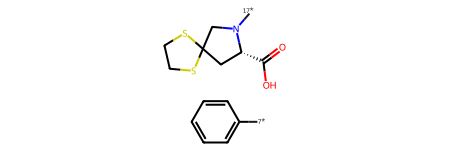

In [90]:
index = 0
drug = drugs_df.iloc[index]
smiles = drug["morphing"]
m = Chem.MolFromSmiles(smiles)
m

In [91]:
smiles

'[7*]c1ccccc1.[17*]N1CC2(C[C@H]1C(=O)O)SCCS2'

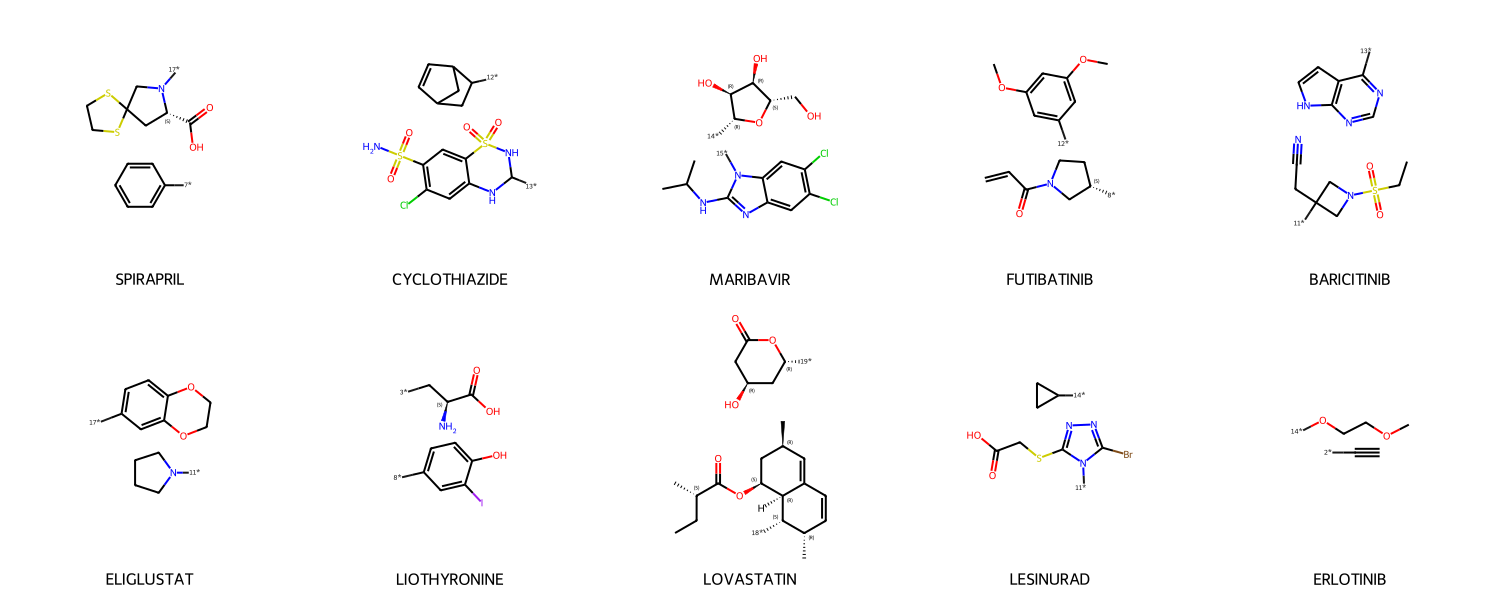

In [80]:
dm.to_image(drugs_df["morphing"].values, legends=drugs_df["pref_name"].tolist(), use_svg=False, n_cols=5, max_mols=50)

slices: ['[8*][C@H]1CCN(C(=O)C=C)C1', '[7*]n1nc(C#C[13*])c2c(N)ncnc21', '[12*]c1cc(OC)cc(OC)c1']
	None
morphing: [8*][C@H]1CCN(C(=O)C=C)C1.[12*]c1cc(OC)cc(OC)c1
	[8*H0][:0chiral][Ring2][C][:0frag10][=Branch][C][=C][pop][=Branch][C][Ring1][=C][pop][pop]
motif: [8*][C@H]1CCN(C(=O)C=C)C1
	[8*H0][:0chiral][Ring2][C][:0frag10][=Branch][C][=C][pop][=Branch][C][Ring1][=C][pop][pop]
scaffold: [1*]N1CC[C@H](n2nc(C#Cc3cc([2*])cc([3*])c3)c3c([4*])ncnc32)C1
	[1*H0][N][C][C][:0chiral][Ring1][N][N][=C][Branch][C][#C][:0frag28][Ring1][3*H0][pop][Ring2][2*H0][pop][pop][C][=C][Branch][4*H0][pop][N][=C][N][=C][Ring2][Ring1][Branch][Ring1][#Branch][pop][Ring1][C][Ring2][Ring1][#C][pop]
superstructure: C(#Cc1nn([C@H]2CCNC2)c2ncncc12)c1ccccc1
	[C][#Branch][#C][C][=N][N][Branch][:0chiral][Ring2][C][C][N][C][Ring1][=Branch][pop][pop][C][=N][C][=N][C][=C][Ring2][Ring1][Ring1][Ring1][=Branch][pop][:0frag28]


[21:08:48] SMILES Parse Error: syntax error while parsing: ['[8*][C@H]1CCN(C(=O)C=C)C1',
[21:08:48] SMILES Parse Error: Failed parsing SMILES '['[8*][C@H]1CCN(C(=O)C=C)C1',' for input: '['[8*][C@H]1CCN(C(=O)C=C)C1','


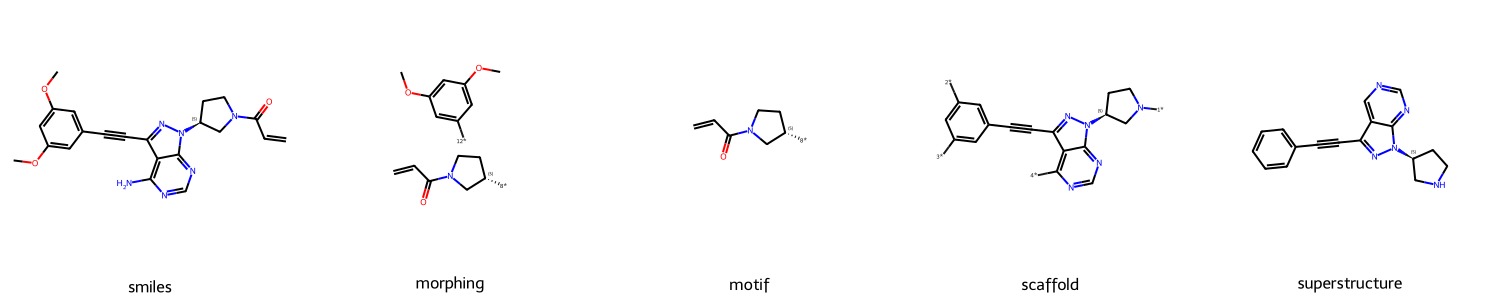

In [80]:
converter = GroupSELFIESConverter(grammar_filepath=GROUP_SELFIES_GRAMMAR_PATH)

index = 3
drug_row = drugs_df.iloc[index]

tasks = ["slices", "morphing", "motif", "scaffold", "superstructure"]
viz_cols = ["smiles"] + tasks[1:]

for task in tasks:
    frag_str = drug_row[task]
    gs_frag_str = converter.encoder(frag_str)
    print(f"{task}: {frag_str}")
    print(f"\t{gs_frag_str}")

dm.to_image(drug_row[viz_cols].values, legends=viz_cols, use_svg=False, n_cols=5, max_mols=50)

In [83]:
import regex

def get_group_selfies_splits(group_selfies_str):
    split_pattern = re.compile(r'\[.+?\]')
    splits = re.findall(split_pattern, group_selfies_str)
    
    return splits

def get_wildcard_indices(splits):
    return [ i for i, s in enumerate(splits) if "*" in s ]
    
smiles_str = drug_row["motif"]
print(smiles_str)
gs_str = converter.encoder(smiles_str)
splits = get_group_selfies_splits(gs_str)
modified_gs_str = "".join(splits[:0:-1])+ "[C]"
# modified_gs_str = "".join(splits[1:]) + "[pop][:4frag10]"
modified_smiles_str = converter.decoder(get_group_selfies_splits(modified_gs_str)[::-1])
# modified_smiles_str = converter.decoder(get_group_selfies_splits(modified_gs_str))
modified_smiles_str

[8*][C@H]1CCN(C(=O)C=C)C1


[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond
[21:09:35] Incomplete atom labelling, cannot make bond


'C=CC(=O)N1CC[C@H](C)C1'

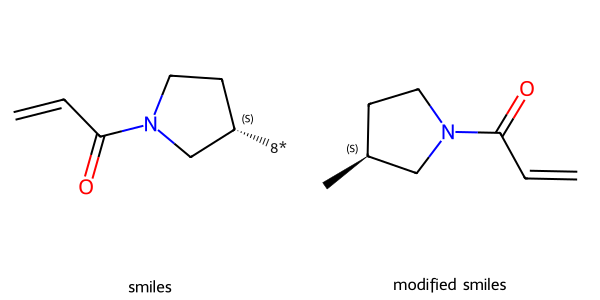

In [84]:
dm.to_image([smiles_str, modified_smiles_str], legends=["smiles", "modified smiles"], use_svg=False, n_cols=5, max_mols=50)


In [93]:
split_pattern = re.compile(r'\[.+?\]')
tokens = re.findall(split_pattern, gs_frag_str)
modified_tokens = []
for t in tokens:
    if "*" in t:
        modified_tokens.append("[C]")
    else:
        modified_tokens.append(t)
        
modified_gs_frag_str = "".join(modified_tokens)

[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond
[22:04:41] Incomplete atom labelling, cannot make bond


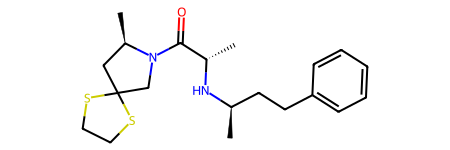

In [77]:
modified_smiles_str = converter.decoder(modified_gs_frag_str)
Chem.MolFromSmiles(modified_smiles_str)

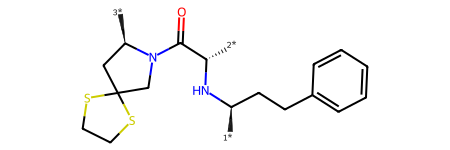

In [79]:
m = Chem.MolFromSmiles(smiles)
m

## Test SAFEDesign Tasks

In [20]:
from safe.sample import SAFEDesign

safe_designer = SAFEDesign.load_default(
                    verbose = False, model_dir = "/home/jonathanlim/safe/safe/expts/output/safe_20M/checkpoint-989860", device = "cuda")


In [21]:
motifs = drugs_df["motif"].values.tolist()

In [26]:
generated = safe_designer.motif_extension(motifs[0], 
                              n_samples_per_trial=10,
                              n_trials=1,
                              sanitize=True
                             )

In [27]:
generated

['O=C(O)[C@@H]1CC2(CN1Cc1ccnc(NCC3CC3)c1)SCCS2',
 'O=C(Nc1nc(CN2CC3(C[C@H]2C(=O)O)SCCS3)cs1)C1CC1',
 'CC1(Nc2cc(CN3CC4(C[C@H]3C(=O)O)SCCS4)ccn2)CC1',
 'O=C(NCC1CC1)c1ccc(CN2CC3(C[C@H]2C(=O)O)SCCS3)o1',
 'O=C(O)[C@@H]1CC2(CN1C(=O)c1ccc(NCC3CC3)cc1)SCCS2',
 'O=C(O)[C@@H]1CC2(CN1C(=O)N(CC1CC1)CC1CC1)SCCS2',
 'O=C(Nc1cc(CN2CC3(C[C@H]2C(=O)O)SCCS3)ccn1)C1CC1',
 'O=C(NC1CC1)c1ccc(CN2CC3(C[C@H]2C(=O)O)SCCS3)o1',
 'O=C(NC1CC1)c1ccc(CN2CC3(C[C@H]2C(=O)O)SCCS3)cc1',
 'O=C(NC1CC1)c1ccc(CN2CC3(C[C@H]2C(=O)O)SCCS3)o1']

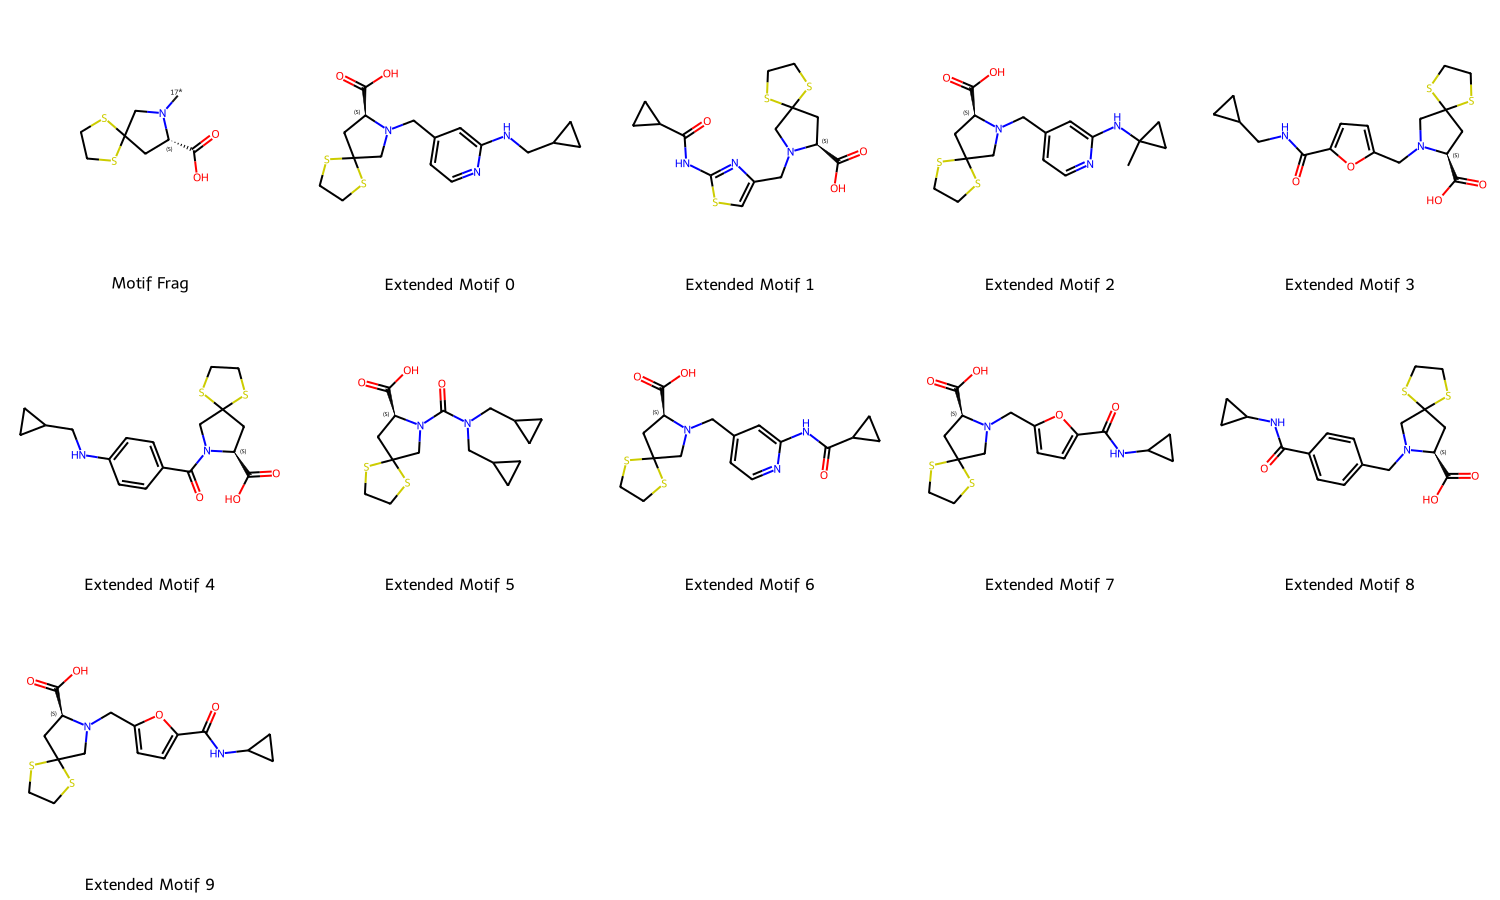

In [28]:
dm.to_image([motifs[0]] + generated, legends=["Motif Frag"] + [f"Extended Motif {i}" for i in range(10)], use_svg=False, n_cols=5, max_mols=50)


In [71]:
# Motif Extension
gs_designer = GroupSELFIESDesign.load_default(verbose=True, 
                                           model_dir="/home/jonathanlim/safe/safe/expts/output/groupselfies_2/checkpoint-244000/",
                                           device = "cuda",
                                           encoder_grammar_filepath=GROUP_SELFIES_GRAMMAR_PATH)

test_mol = motifs[0]
generated = gs_designer.motif_extension(test_mol, 
                              n_samples_per_trial=10,
                              n_trials=1,
                              sanitize=True
                             )

generated

  0%|          | 0/1 [00:00<?, ?it/s]

[17*]N1CC2(C[C@H]1C(=O)O)SCCS2 [17*H0][N][C][C][Branch][C][:2chiral][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]
['[#C][Ring1][S][C][C][S][pop][pop][Branch][Ring1][Ring2][pop][O][pop][=O][=Branch][C][Ring2][C][Branch][C][C][N][Branch][C][=N][C][=C][S][Ring1][Branch][pop][C][Ring1][P][pop][Ring1][O]', '[#C][Ring1][S][C][C][S][pop][pop][Branch][Ring1][Ring2][pop][O][pop][=O][=Branch][C][Ring2][C][Branch][C][C][N][Branch][:0frag27][pop][C][Ring1][O][pop][Ring1][O][pop]', '[#C][Ring1][S][C][C][S][pop][pop][Branch][Ring1][Ring2][pop][O][pop][=O][=Branch][C][Ring2][C][Branch][C][C][N][Branch][C][=N][C][=C][C][=N][Ring1][=Branch][pop][C][C][Ring1][#C][pop][Ring1][Ring1]', '[#C][Ring1][S][C][C][S][pop][pop][Branch][Ring1][Ring2][pop][O][pop][=O][=Branch][C][Ring2][C][Branch][C][C][N][Branch][C][=C][C][=C][S][Ring1][Branch][pop][Ring1][O][pop][C][Ring2][Ring1][C]', '[#C][Ring1][S][C][C][S][pop][pop][Branch][Ring1][Ring2][pop][O][pop][=O][=Branch][C

['[O][Ring1][pop][P][Ring1][C][pop][Branch][Ring1][S][=C][C][=N][C][Branch][N][C][C][Branch][C][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]',
 '[pop][O][Ring1][pop][O][Ring1][C][pop][:0frag27][Branch][N][C][C][Branch][C][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]',
 '[Ring1][Ring1][pop][#C][Ring1][C][C][pop][=Branch][Ring1][=N][C][=C][C][=N][C][Branch][N][C][C][Branch][C][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]',
 '[C][Ring1][Ring2][C][pop][O][Ring1][pop][Branch][Ring1][S][=C][C][=C][C][Branch][N][C][C][Branch][C][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]',
 '[#Branch][Ring1][pop][#C][Ring1][C][C][pop][=Branch][Ring1][=N][C][=C][C][=N][C][Branch][N][C][C][Branch][C][Ring2][C][=Branch][=O][pop][O][pop][Ring2][Ring1][Branch][pop][pop][S][C][C][S][Ring1][#C]',
 '[pop][N][Ring1][pop][#C][Ring1][C][

In [69]:
converted = [ converter.decoder(x) for x in generated ] 
converted

[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond
[20:57:29] Incomplete atom labelling, cannot make bond


['O=O',
 'O=O',
 'O=CC(O)CNc1cncc(CN2CC2)n1',
 'C#N',
 'N=O',
 'O=CC(O)CNc1cc2cc(c1CCS)N2',
 'O=C1C(O)CNC23C=C=CC=NC12SCCS3',
 'O=CC(O)CNc1ncc2c(c1CCS)C(=O)C2',
 'O=C1C2=CC=C3C#P3C2(SCCS)NCC1O',
 'O=CC=CC=CC12SCCSC1NCC(O)C2=O']

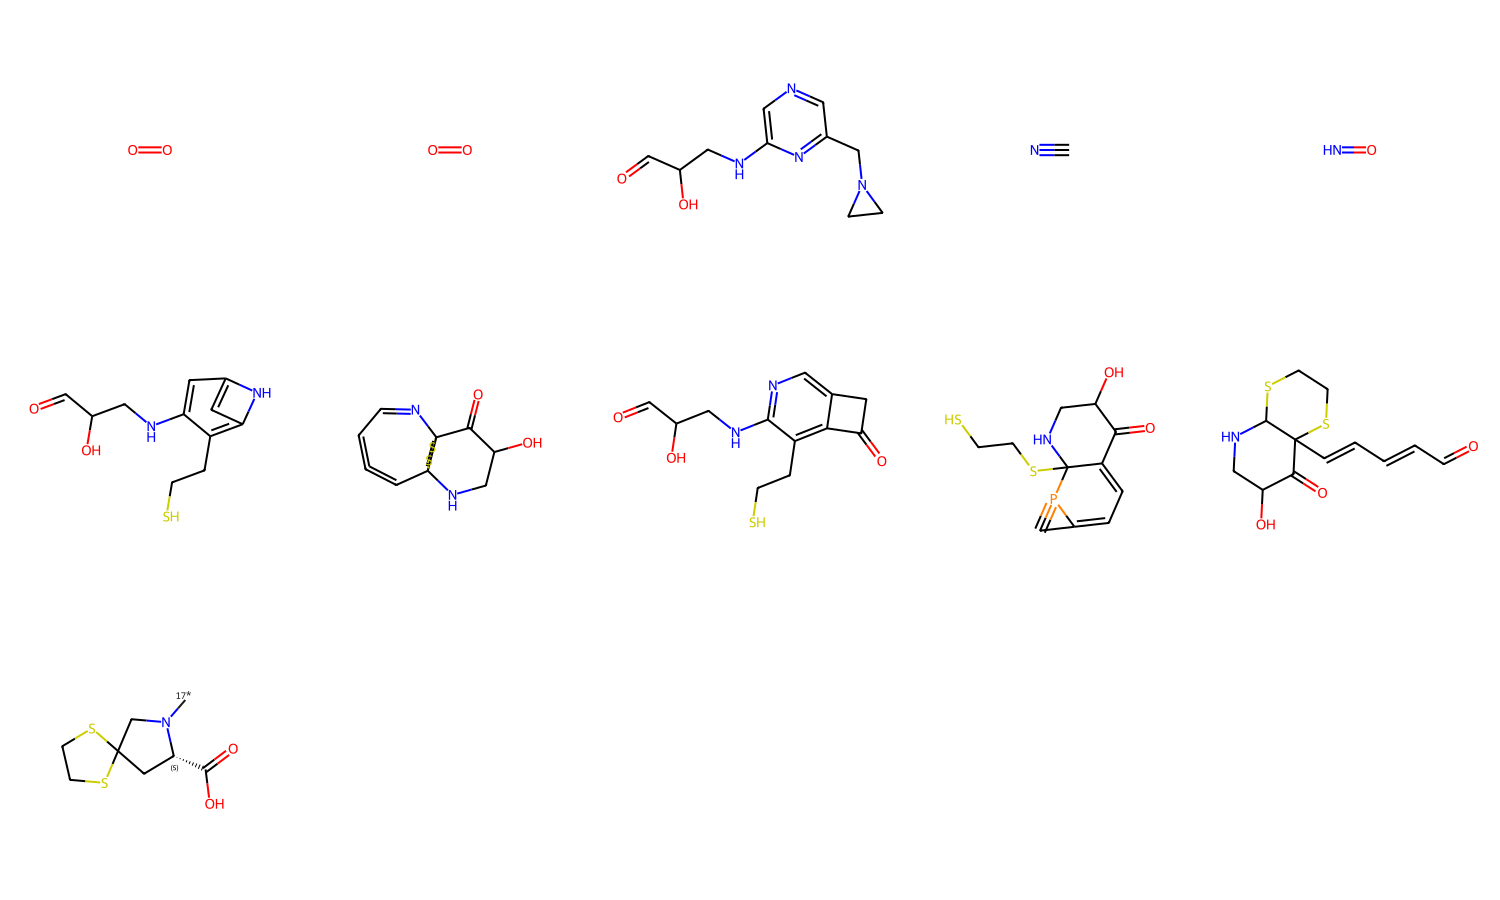

In [72]:
dm.to_image(converted + [test_mol], use_svg=False, n_cols=5, max_mols=50)